# Cell Types Project Master Notebook

In [1]:
#Import the "Cell Types Cache" from the AllenSDK core package
from allensdk.core.cell_types_cache import CellTypesCache

#Import CellTypesApi, which will allow us to query the database.
from allensdk.api.queries.cell_types_api import CellTypesApi

# initialize cache as 'ctc' (cell types cache)
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# import tool used to get AP spike data for specimen
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

import pandas as pd
import numpy as np

# get rid of all the ugly red warnings
import warnings
warnings.filterwarnings('ignore')

The paper used mouse data, so filter to get only mouse specimen.

In [2]:
mouse_cells_df = pd.DataFrame(ctc.get_cells(species = ['mus musculus']))
mouse_ids_df = mouse_cells_df[['id','dendrite_type']].set_index('id')
mouse_ids_df

,dendrite_type
id,
565871768,aspiny
469801138,aspiny
605889373,aspiny
485909730,spiny
323865917,spiny
...,...
512322162,spiny
488473535,aspiny
467003163,spiny


Get ephys features.

In [3]:
ephys_features_df = pd.DataFrame(ctc.get_ephys_features())
ephys_ids_df = ephys_features_df[['specimen_id','rheobase_sweep_number']].set_index('specimen_id')
ephys_ids_df.shape

(2333, 1)

Use inner join to get specimen ids of only mouse species that have ephys data.

Assuming 'id' in mouse cells df the same as 'specimen id' in ephys data, we can get the rheobase sweep number for each mouse specimen.

In [4]:
me_rheobase_df = mouse_ids_df.join(ephys_ids_df).reset_index()
me_rheobase_df = me_rheobase_df.rename(columns={"id": "specimen_id"})

# this df has mouse ephys rheobase data
me_rheobase_df

,specimen_id,dendrite_type,rheobase_sweep_number
0,565871768,aspiny,40
1,469801138,aspiny,57
2,605889373,aspiny,53
3,485909730,spiny,33
4,323865917,spiny,34
...,...,...,...
1915,512322162,spiny,44
1916,488473535,aspiny,57
1917,467003163,spiny,45
1918,572609946,aspiny,45


Get the morphology dataset.

In [5]:
morph_feats_df = pd.DataFrame(ctc.get_morphology_features())
morph_feats_df.shape

(671, 30)

Now we use the morphology dataset to select for specimen that are mice, have ephys data, and have morphology data by performing an inner merge of the two datasets.

In [6]:
ephys_morph_mice_df = me_rheobase_df.merge(morph_feats_df,on='specimen_id', how= 'inner')

# this contains the ids of the mice with ephys and morph data
df_ids = ephys_morph_mice_df[['specimen_id']]
# make ephys df of only the mice with morphology and ephys data
ephys_df = ephys_features_df.merge(df_ids, on='specimen_id', how='inner')
# make morphology df of only the mice with morphology and ephys data
morph_df = morph_feats_df.merge(df_ids, on='specimen_id', how='inner')

morph_df ## TODO HOW DOES THIS HAVE MORE ROWS THAN DF_IDS??? IT SHOULDNT

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id,max_branch_order,max_euclidean_distance,...,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,specimen_id,superseded,tags,total_length,total_surface,total_volume
0,82.727781,NaN,0.864267,0.345092,20.723077,0.964510,NaN,491119743,6.0,99.779724,...,0.1144,0.1144,0.28,435.740270,478107198,False,3D Neuron Reconstruction morphology,1666.082926,1803.875644,167.343086
1,82.506680,NaN,0.903890,0.634047,105.277778,0.862183,NaN,546781359,3.0,432.383110,...,0.1144,0.1144,0.28,1446.587725,502367941,False,3D Neuron Reconstruction morphology,2277.259374,4543.139073,921.571895
2,77.536678,NaN,0.863104,0.417929,73.666667,0.926633,NaN,537042261,6.0,373.630444,...,0.1144,0.1144,0.28,287.118123,515771244,False,3D Neuron Reconstruction morphology,3589.339062,4704.910407,582.285423
3,72.019250,NaN,0.873518,0.227626,47.535714,1.000000,NaN,657879305,5.0,186.218009,...,0.1144,0.1144,0.28,55.055236,591268268,False,3D Neuron Reconstruction morphology,1659.465869,1185.773462,69.144146
4,68.459909,NaN,0.889767,0.259649,28.263158,1.085194,NaN,491120305,6.0,107.897533,...,0.1144,0.1144,0.28,358.755159,469753383,False,3D Neuron Reconstruction morphology,1825.646321,1499.858295,108.114604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,79.045450,NaN,0.908527,0.266125,18.546667,0.994179,NaN,572837209,8.0,98.478472,...,0.1144,0.1144,0.28,111.513116,560965993,False,3D Neuron Reconstruction morphology,1750.889026,1471.007686,96.914659
515,77.794711,NaN,0.882325,0.229117,39.222222,0.987653,NaN,605859502,7.0,324.981751,...,0.1144,0.1144,0.28,89.296453,577369606,False,3D Neuron Reconstruction morphology,3010.472348,2169.044090,124.499006
516,92.342737,NaN,0.827214,0.543099,73.500000,1.000000,NaN,652192441,8.0,462.000946,...,0.1144,0.1144,0.28,910.267909,580007431,False,3D Neuron Reconstruction morphology,2816.628822,4800.788927,671.972010
517,68.973566,NaN,0.902848,0.355087,39.833333,0.904651,NaN,495889701,3.0,218.855968,...,0.1144,0.1144,0.28,268.001597,333785935,False,3D Neuron Reconstruction morphology,1958.562393,2188.064195,206.225429


Classify each specimen as inhibitory or excitatory by accessing their dendrite type in the `.get_cells()` method.

In [7]:
def classify(specimen_id):
    '''classifies a specimen as inhibitory or excitatory based on if its spiny or aspiny'''
    a_or_s = mouse_ids_df.loc[specimen_id]['dendrite_type']
    
    if a_or_s == 'spiny':
        return 'excitatory'
    else:
        return 'inhibitory'

Add inhib or excitatory columns to ephys and morphology data.

In [8]:
ephys_df['inhib/excit'] = ephys_df['specimen_id'].apply(classify)
ephys_df

,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,...,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest,inhib/excit
0,0.044825,91.322222,-46.761876,0.223864,1.190240,3.826338,1.025363,-44.937504,-43.635419,-47.395833,...,1.806510,-50.875000,-50.989586,-76.791669,2.992793,2.817856,2.706951,-96.906250,-75.320374,excitatory
1,0.002303,8.756140,-33.787497,0.636671,1.729100,16.728967,1.023988,-60.968754,-63.145835,-66.856253,...,1.298640,-61.031254,-65.000005,-79.625003,0.987204,1.191762,1.294996,-85.593750,-79.520042,inhibitory
2,0.008008,42.867391,-111.638115,0.325524,1.101295,1.775697,1.025883,-67.406250,-66.593753,-67.802085,...,1.054124,-67.656250,-66.791669,-68.546875,2.350017,2.142121,2.262525,-100.187500,-66.241074,inhibitory
3,0.011140,44.374545,-28.642500,0.286192,1.060140,2.981870,1.025220,-47.531250,-48.437502,-51.054690,...,1.631545,-47.593754,-48.562502,-69.421877,3.782685,3.628545,4.015633,-99.187508,-68.897186,inhibitory
4,0.059450,238.470000,-11.630000,0.151066,1.095720,8.038240,1.025250,-49.406254,-48.479170,-57.390629,...,1.188280,-50.968750,-51.562501,-78.906254,2.320162,2.316604,2.936915,-95.500008,-83.018768,excitatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.002757,12.574038,6.654375,0.824576,1.029555,11.073320,1.024212,-60.500000,-52.291667,-61.187501,...,1.554089,-60.531250,-52.479168,-72.382816,1.557328,1.374809,1.648069,-84.687500,-72.372963,inhibitory
509,0.005915,15.761354,18.873125,0.985833,1.034245,13.615353,1.024267,-60.593750,-58.093753,-63.350003,...,1.657443,-60.750000,-58.177085,-74.900002,1.447790,1.356713,1.564442,-84.781250,-74.044434,inhibitory
510,0.047238,11.168750,-29.520626,1.443365,1.029680,16.606880,1.024076,-65.312508,-61.281254,-66.612503,...,1.224035,-65.375000,-61.281254,-75.725002,1.405709,1.144006,1.397237,-85.031250,-74.639656,inhibitory
511,0.055722,99.903333,-7.551875,0.157034,1.191825,4.424122,1.024840,-47.750000,-47.281250,-51.416667,...,1.531288,-54.906254,-54.937500,-79.260419,2.874551,2.984296,3.248583,-97.218750,-78.721344,excitatory


In [9]:
morph_df['inhib/excit'] = morph_df['specimen_id'].apply(classify)
morph_df = morph_df.set_index('specimen_id')
morph_df

,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,hausdorff_dimension,id,max_branch_order,max_euclidean_distance,...,scale_factor_x,scale_factor_y,scale_factor_z,soma_surface,superseded,tags,total_length,total_surface,total_volume,inhib/excit
specimen_id,,,,,,,,,,,,,,,,,,,,,
478107198,82.727781,NaN,0.864267,0.345092,20.723077,0.964510,NaN,491119743,6.0,99.779724,...,0.1144,0.1144,0.28,435.740270,False,3D Neuron Reconstruction morphology,1666.082926,1803.875644,167.343086,inhibitory
502367941,82.506680,NaN,0.903890,0.634047,105.277778,0.862183,NaN,546781359,3.0,432.383110,...,0.1144,0.1144,0.28,1446.587725,False,3D Neuron Reconstruction morphology,2277.259374,4543.139073,921.571895,excitatory
515771244,77.536678,NaN,0.863104,0.417929,73.666667,0.926633,NaN,537042261,6.0,373.630444,...,0.1144,0.1144,0.28,287.118123,False,3D Neuron Reconstruction morphology,3589.339062,4704.910407,582.285423,excitatory
591268268,72.019250,NaN,0.873518,0.227626,47.535714,1.000000,NaN,657879305,5.0,186.218009,...,0.1144,0.1144,0.28,55.055236,False,3D Neuron Reconstruction morphology,1659.465869,1185.773462,69.144146,inhibitory
469753383,68.459909,NaN,0.889767,0.259649,28.263158,1.085194,NaN,491120305,6.0,107.897533,...,0.1144,0.1144,0.28,358.755159,False,3D Neuron Reconstruction morphology,1825.646321,1499.858295,108.114604,inhibitory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560965993,79.045450,NaN,0.908527,0.266125,18.546667,0.994179,NaN,572837209,8.0,98.478472,...,0.1144,0.1144,0.28,111.513116,False,3D Neuron Reconstruction morphology,1750.889026,1471.007686,96.914659,inhibitory
577369606,77.794711,NaN,0.882325,0.229117,39.222222,0.987653,NaN,605859502,7.0,324.981751,...,0.1144,0.1144,0.28,89.296453,False,3D Neuron Reconstruction morphology,3010.472348,2169.044090,124.499006,inhibitory
580007431,92.342737,NaN,0.827214,0.543099,73.500000,1.000000,NaN,652192441,8.0,462.000946,...,0.1144,0.1144,0.28,910.267909,False,3D Neuron Reconstruction morphology,2816.628822,4800.788927,671.972010,excitatory


In [10]:
# also drop columns that arent quantitative, aside from the inhib/excit columns
morph_df = morph_df.drop(columns=['superseded','tags','neuron_reconstruction_type'])

In [11]:
# check for null values
morph_df.isnull().sum()

average_bifurcation_angle_local       0
average_bifurcation_angle_remote    519
average_contraction                   0
average_diameter                      0
average_fragmentation                 0
average_parent_daughter_ratio         0
hausdorff_dimension                 519
id                                    0
max_branch_order                      0
max_euclidean_distance                0
max_path_distance                     0
number_bifurcations                   0
number_branches                       0
number_nodes                          0
number_stems                          0
number_tips                           0
overall_depth                         0
overall_height                        0
overall_width                         0
scale_factor_x                        0
scale_factor_y                        0
scale_factor_z                        0
soma_surface                          0
total_length                          0
total_surface                         0


morph_df has nan for all of its values in 'hausdorff_dimension' and 'average_bifurcation_angle_remote', so get rid of those columns

In [21]:
# dont include columns in morph_df unrelated to morphology (ie. id numbers)
morph_columns = list(morph_df.columns)
morph_columns.remove('id')
morph_columns.remove('average_bifurcation_angle_remote')
morph_columns.remove('hausdorff_dimension')
morph_columns.remove('inhib/excit')
morph_columns


['average_bifurcation_angle_local',
 'average_contraction',
 'average_diameter',
 'average_fragmentation',
 'average_parent_daughter_ratio',
 'max_branch_order',
 'max_euclidean_distance',
 'max_path_distance',
 'number_bifurcations',
 'number_branches',
 'number_nodes',
 'number_stems',
 'number_tips',
 'overall_depth',
 'overall_height',
 'overall_width',
 'scale_factor_x',
 'scale_factor_y',
 'scale_factor_z',
 'soma_surface',
 'total_length',
 'total_surface',
 'total_volume']

In [22]:
inhib_morph_df = morph_df[morph_df['inhib/excit'] == 'inhibitory'].drop(columns = ['inhib/excit'])
excit_morph_df = morph_df[morph_df['inhib/excit'] == 'excitatory'].drop(columns = ['inhib/excit'])
print("inhib df shape:" + str(inhib_morph_df.shape))
print("excit df shape:" + str(excit_morph_df.shape))

inhib df shape:(279, 26)
excit df shape:(240, 26)


Note that the number of rows differ by 30.

Plot zscores

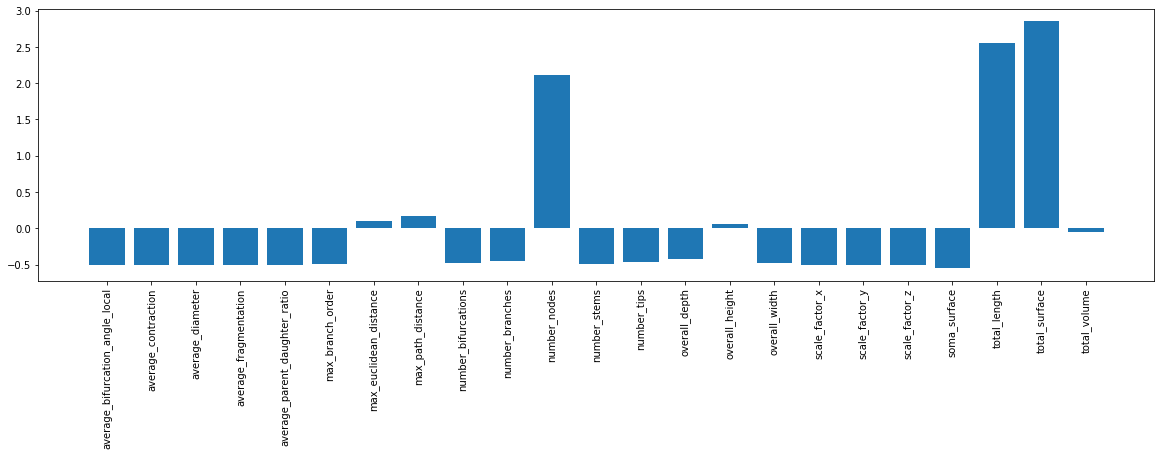

In [26]:
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set up the figure
fig,ax = plt.subplots(figsize=(20,5))

differences = []

for i in morph_columns:
    inhib_mean = np.mean(inhib_morph_df[i])
    excit_mean = np.mean(excit_morph_df[i])
    differences.append(excit_mean - inhib_mean)

diff_zscore = stats.zscore(differences)
ax.bar(morph_columns, diff_zscore)
plt.xticks(rotation=90)

plt.show()

In [ ]:
def calc_spike_width(specimen_id):
    ''' calculates the spike width using specimen id to get the data. returns 0.0 if file does not exist'''
    try:
        data_set = ctc.get_ephys_data(specimen_id)
        sweep_number = rheobases_df.loc[specimen_id]['rheobase_sweep_number']
        sweep_data = data_set.get_sweep(sweep_number)

        index_range = sweep_data["index_range"]
        i = sweep_data["stimulus"][0:index_range[1]+1] # in A
        v = sweep_data["response"][0:index_range[1]+1] # in V
        i *= 1e12 # to pA
        v *= 1e3 # to mV

        sampling_rate = sweep_data["sampling_rate"] # in Hz
        t = np.arange(0, len(v)) * (1.0 / sampling_rate)

        sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
        sweep_ext.process_spikes()

        return round(1e3 * np.nanmean(sweep_ext.spike_feature("width")),4)
    
    except OSError as e:
        return 0.0